Necessary Imports:

Catlab provides support for Categorical Algebra used by other libraries
AlgebraicPetri and AlgebraicDynamics are essential for petri-net modelling of dynamical systems
They interface petri-nets with categorical constructs with "vectorfields"

Differential Equations, Plots for obvious reasons, LabelledArrays provide support for "labelled" vectors

In [2]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams, Catlab.Graphics 
using AlgebraicPetri 
using AlgebraicDynamics.UWDDynam 

using DifferentialEquations 

using LabelledArrays 
using Plots

LabelledPetriNet essentially adds names to every object in the FinSet representing TISO of the PetriNet
Open is a transform taking the labelled petri net to a structured multi cospan (turning the closed system into an exposed and open one)

In [3]:
# A Lotka Volterra Model dealing with Foxes and Rabbits
LV = Open(LabelledPetriNet(
    [:Fox, :Rabbit], 
    :birth_rabbit => ((:Rabbit) => (:Rabbit, :Rabbit)),
    :death_fox => ((:Fox) => ()),
    :predation_rabbit => ((:Rabbit, :Fox) => (:Fox, :Fox))
    ))

# Navin's Pigeon Model
N = Open(LabelledPetriNet([:Fox, :Pigeon], 
    :birth_pigeon => ((:Pigeon) => (:Pigeon, :Pigeon)),
    :death_pigeon => ((:Pigeon) => ()),
    :pigeon_eaten => ((:Pigeon, :Fox) => (:Fox))
)
)

# Aditi's Bear Model
A = Open(LabelledPetriNet([:Fox, :Bear], 
    :birth_bear => ((:Bear) => (:Bear, :Bear)),
    :death_bear => ((:Bear) => ()),
    :predation_fox => ((:Bear, :Fox) => (:Bear, :Bear))
)
)

# Shivanshu's Fish Model
S = Open(LabelledPetriNet([:Fox, :Bear, :Fish], 
    :birth_fish => ((:Fish) => (:Fish, :Fish)),
    :predation_fish_bear => ((:Fish, :Bear) => (:Bear, :Bear)),
    :predation_fish_fox => ((:Fish, :Fox) => (:Fox))
)
)

# Achintya's Cat Model
Ac = Open(LabelledPetriNet([:Cat, :Fish, :Pigeon], 
    :birth_cat => ((:Cat) => (:Cat, :Cat)),
    :predation_fish_cat => ((:Fish, :Cat) => (:Cat, :Cat)),
    :predation_pigeon_cat => ((:Pigeon, :Cat) => (:Cat, :Cat)),
    :death_cat => ((:Cat)=>())
)
)

# Madhav's lion Model
ML = Open(LabelledPetriNet([:Lion, :Cat, :Rabbit, :Fox], 
:predation_cat_lion => ((:Lion, :Cat) => (:Lion, :Lion)),
:predation_rabbit_lion => ((:Lion, :Rabbit) => (:Lion, :Lion)),
:predation_fox_lion => ((:Lion, :Fox) => (:Lion, :Lion)),
    :death_lion => ((:Lion)=>())
)
)

# Shweta's hedgehog
HG = Open(LabelledPetriNet([:Hedgehog, :Fish], 
:predation_fish_hog => ((:Hedgehog, :Fish) => (:Hedgehog)),
:hedgehog_birth => ((:Hedgehog) => (:Hedgehog, :Hedgehog)),
:hedgehog_death => ((:Hedgehog)) => ())
)


StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{AnonACSet{TypeLevelBasicSchema{Symbol, Tuple{:S}, Tuple{}, Tuple{:Name}, Tuple{(:sname, :S, :Name)}, Tuple{}}, Tuple{Symbol}, @NamedTuple{S::IntParts, Name::IntParts}, @NamedTuple{sname::ACSets.ColumnImplementations.DenseColumn{Union{AttrVar, Symbol}, Vector{Union{AttrVar, Symbol}}}}, IntParts}, LabelledPetriNet}, Multicospan{LabelledPetriNet, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:T, :S, :I, :O}, Tuple{(:it, :I, :T), (:is, :I, :S), (:ot, :O, :T), (:os, :O, :S)}, Tuple{:Name}, Tuple{(:tname, :T, :Name), (:sname, :S, :Name)}, Tuple{}}, @NamedTuple{T::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, S::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, I::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Categ

Here we create a UWD which provides the operad algebra used to compose the structured multi cospans


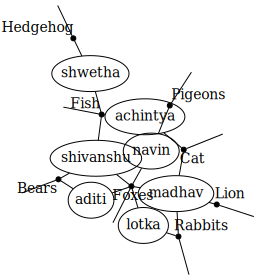

In [4]:
forest_composition_pattern = @relation (Foxes, Pigeons, Rabbits, Bears, Fish, Cat, Lion, Hedgehog) where (Foxes, Pigeons, Rabbits, Bears, Fish, Cat, Lion, Hedgehog) begin
    lotka(Foxes, Rabbits)
    navin(Foxes, Pigeons)
    aditi(Foxes, Bears)
    shivanshu(Foxes, Bears, Fish)
    achintya(Cat, Fish, Pigeons)
    madhav(Lion, Cat, Rabbits, Foxes)
    shwetha(Hedgehog, Fish)
end 

to_graphviz(forest_composition_pattern, box_labels = :name, junction_labels = :variable)

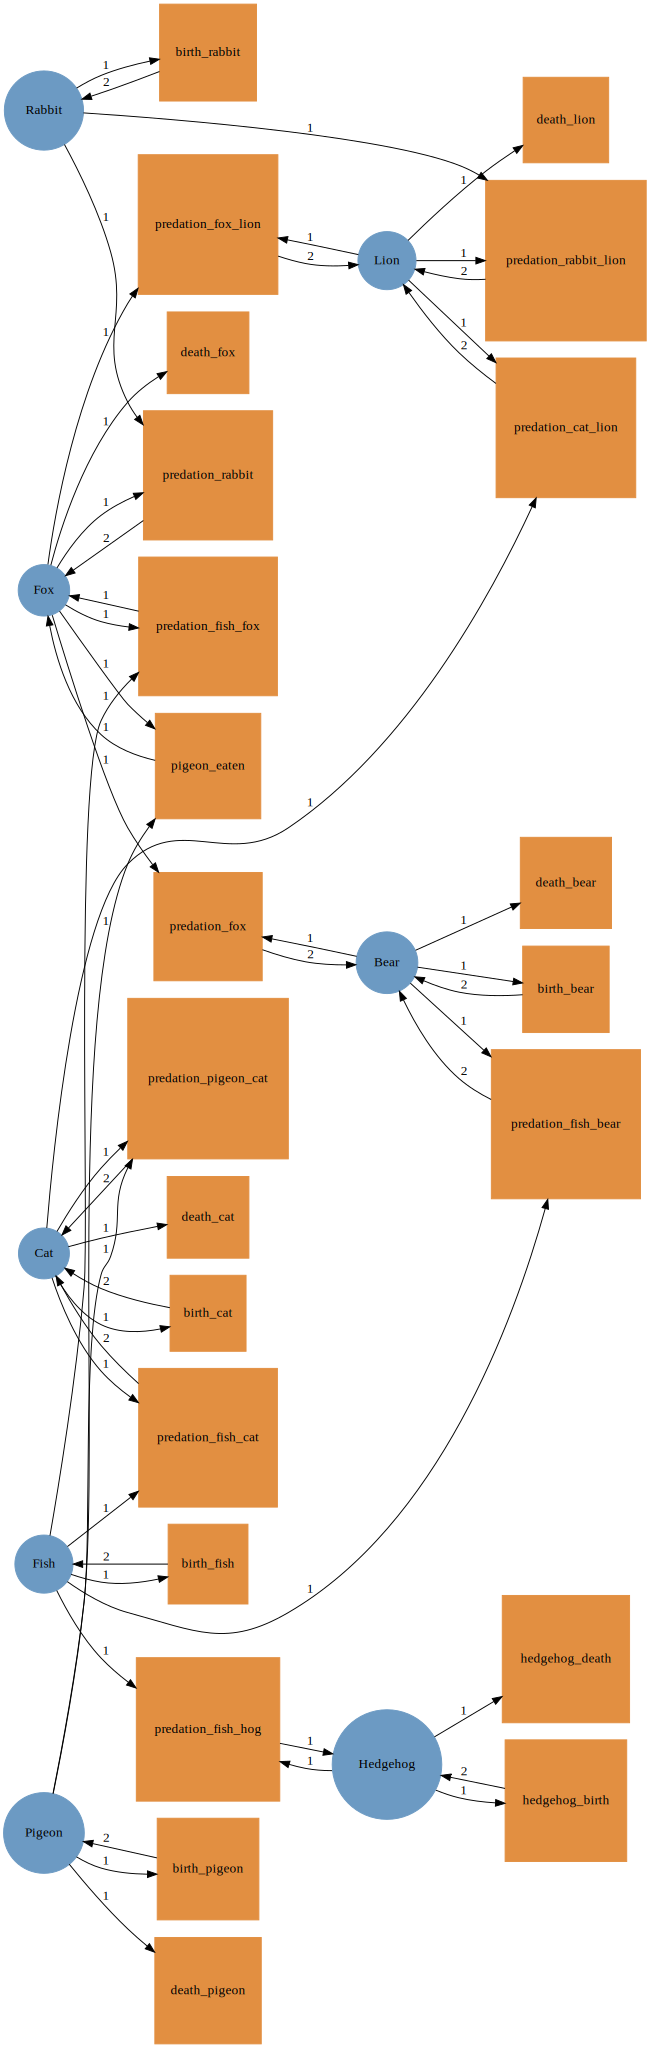

In [5]:
forest_composite = oapply(forest_composition_pattern, 
    Dict(   :lotka => LV,   :navin => N, :aditi => A, :shivanshu => S, :achintya => Ac, :madhav => ML, :shwetha => HG )
)

to_graphviz(forest_composite, program="neato")

In [6]:

prey_reproduction_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u, p, t) -> p.alpha * u, [1])
predator_death_dynamics = ContinuousResourceSharer{Float64}(1, 1, (u, p, t) -> -p.gamma * u, [1])
fair_predation_dynamics = ContinuousResourceSharer{Float64}(2, 2, (u, p, t) -> [p.delta * u[1] * u[2], -p.beta * u[1] * u[2]], [1, 2])
unfair_predation_dynamics = ContinuousResourceSharer{Float64}(2, 2, (u, p, t) -> [0, -p.beta * u[1] * u[2]], [1, 2])


ContinuousResourceSharer(ℝ^2 → ℝ^2) with 2 exposed ports

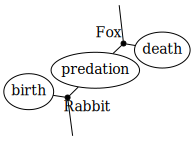

In [7]:
lotka_composition_pattern = @relation (Fox, Rabbit) where (Fox, Rabbit) begin   
    birth(Rabbit)   
    predation(Fox, Rabbit)   
    death(Fox) 
end  

to_graphviz(lotka_composition_pattern,  box_labels = :name, junction_labels = :variable)

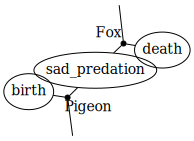

In [8]:
navin_composition_pattern = @relation (Fox, Pigeon) where (Fox, Pigeon) begin   
    birth(Pigeon)   
    sad_predation(Fox, Pigeon)   
    death(Fox) 
end  

to_graphviz(navin_composition_pattern,  box_labels = :name, junction_labels = :variable)

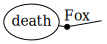

In [9]:
fox_death_pattern = @relation (Fox,) begin
    death(Fox) 
end  

to_graphviz(fox_death_pattern,  box_labels = :name, junction_labels = :variable)

In [10]:
#TODO get UWD from petrinet forest joined at fox

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase /home/navin/.julia/packages/SciMLBase/8XHkk/src/performance_warnings.jl:32


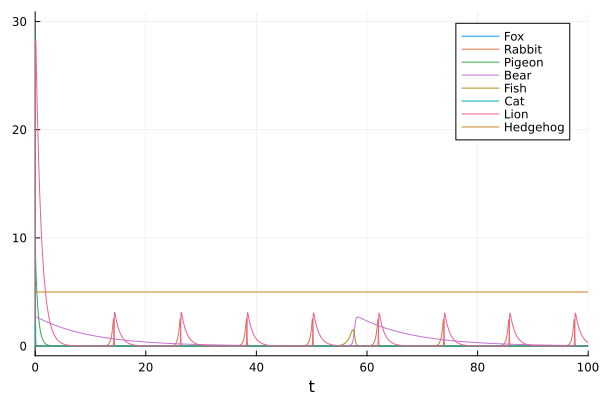

In [11]:
p = LVector(birth_rabbit=3, birth_pigeon=2, death_fox=1, 
predation_rabbit=2, pigeon_eaten=3, death_pigeon=4, birth_bear = 1,
 death_bear = 1.1, predation_fox = 0.4, birth_fish=4, predation_fish_fox=20, 
 predation_fish_bear=3, birth_cat=2, predation_fish_cat = 3, predation_pigeon_cat = 1, 
 death_cat=3, death_lion = 1, predation_cat_lion = 2, predation_fox_lion = 3, predation_rabbit_lion = 10,
 predation_fish_hog= 0.5,
 hedgehog_birth = 1,
 hedgehog_death = 1
 )
u0 = LVector(Fox=5, Rabbit=6, Pigeon=30, Bear =2, Fish=10, Cat=7, Lion=2, Hedgehog=5)
soln = solve(ODEProblem(vectorfield(apex(forest_composite)), u0, (0.0, 100.0), p))
plot(soln)

In [12]:
apex(forest_composite)

LabelledPetriNet {T:23, S:8, I:34, O:31, Name:0}
┌────┬───────────────────────┐
│  T │                 tname │
├────┼───────────────────────┤
│  1 │          birth_rabbit │
│  2 │             death_fox │
│  3 │      predation_rabbit │
│  4 │          birth_pigeon │
│  5 │          death_pigeon │
│  6 │          pigeon_eaten │
│  7 │            birth_bear │
│  8 │            death_bear │
│  9 │         predation_fox │
│ 10 │            birth_fish │
│ 11 │   predation_fish_bear │
│ 12 │    predation_fish_fox │
│ 13 │             birth_cat │
│ 14 │    predation_fish_cat │
│ 15 │  predation_pigeon_cat │
│ 16 │             death_cat │
│ ⋮  │           ⋮           │
└────┴───────────────────────┘
                7 rows omitted
┌───┬──────────┐
│ S │    sname │
├───┼──────────┤
│ 1 │      Fox │
│ 2 │   Rabbit │
│ 3 │   Pigeon │
│ 4 │     Bear │
│ 5 │     Fish │
│ 6 │      Cat │
│ 7 │     Lion │
│ 8 │ Hedgehog │
└───┴──────────┘
┌────┬────┬────┐
│  I │ it │ is │
├────┼────┼────┤
│  1 │  1 │  2 │
│  2 │  2 │  1 │
│  3 │  3 │  2 │
│  4 │  3 │  1 │
│  5 │  4 │  3 │
│  6 │  5 │  3 │
│  7 │  6 │  3 │
│  8 │  6 │  1 │
│  9 │  7 │  4 │
│ 10 │  8 │  4 │
│ 11 │  9 │  4 │
│ 12 │  9 │  1 │
│ 13 │ 10 │  5 │
│ 14 │ 11 │  5 │
│ 15 │ 11 │  4 │
│ 16 │ 12 │  5 │
│ ⋮  │ ⋮  │ ⋮  │
└────┴────┴────┘
 18 rows omitted
┌────┬────┬────┐
│  O │ ot │ os │
├────┼────┼────┤
│  1 │  1 │  2 │
│  2 │  1 │  2 │
│  3 │  3 │  1 │
│  4 │  3 │  1 │
│  5 │  4 │  3 │
│  6 │  4 │  3 │
│  7 │  6 │  1 │
│  8 │  7 │  4 │
│  9 │  7 │  4 │
│ 10 │  9 │  4 │
│ 11 │  9 │  4 │
│ 12 │ 10 │  5 │
│ 13 │ 10 │  5 │
│ 14 │ 11 │  4 │
│ 15 │ 11 │  4 │
│ 16 │ 12 │  1 │
│ ⋮  │ ⋮  │ ⋮  │
└────┴────┴────┘
 15 rows omitted

In [13]:
LV

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{AnonACSet{TypeLevelBasicSchema{Symbol, Tuple{:S}, Tuple{}, Tuple{:Name}, Tuple{(:sname, :S, :Name)}, Tuple{}}, Tuple{Symbol}, @NamedTuple{S::IntParts, Name::IntParts}, @NamedTuple{sname::ACSets.ColumnImplementations.DenseColumn{Union{AttrVar, Symbol}, Vector{Union{AttrVar, Symbol}}}}, IntParts}, LabelledPetriNet}, Multicospan{LabelledPetriNet, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:T, :S, :I, :O}, Tuple{(:it, :I, :T), (:is, :I, :S), (:ot, :O, :T), (:os, :O, :S)}, Tuple{:Name}, Tuple{(:tname, :T, :Name), (:sname, :S, :Name)}, Tuple{}}, @NamedTuple{T::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, S::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, I::Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Categ